**<center> Joaquin Peñuela Parra, Cristian Fernando Rodriguez Cruz <center>**
**<center> University of Los Andes <center>**
**<center> High Energy Physics Group: Phenomenology of Particles <center>**

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import pickle
from scipy.interpolate import CubicSpline

import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"

!git clone https://github.com/Phenomenology-group-uniandes/Heatmap_Utilities.git
import nbimporter
sys.path.append(f'{os.getcwd()}/Heatmap_Utilities')
from Heatmap_Utilities.Main_Functions import smooth, plot_heatmap

Cloning into 'Heatmap_Utilities'...
remote: Enumerating objects: 62, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 62 (delta 28), reused 36 (delta 13), pack-reused 0
Receiving objects: 100% (62/62), 2.70 MiB | 3.15 MiB/s, done.
Resolving deltas: 100% (28/28), done.


In [2]:
path_statistical_preparation = os.path.join(os.path.dirname(os.getcwd()), '06_Statistical_Preparation')

In [3]:
def approx_global_sig(sig: np.array, bkg: np.array, N: float = 0.0) -> float:
    """
    Calculates the statistical significance of a signal over background in a given dataset using a modified version of
    the formula (S -N sqrt(B))/sqrt(S+B), where S is the number of signal events, B is the number of background events,
    and N is the expected number of background events in the signal region.

    Parameters:
    sig (np.array): 1D array containing the number of signal events in each bin of the dataset.
    bkg (np.array): 1D array containing the number of background events in each bin of the dataset.
    N (float): Expected number of background events in the signal region. Default value is 0.0.

    Returns:
    float: The statistical significance of the signal over background in the dataset.
    """

    # calculate weight factor w for each bin
    w = np.log(1. + sig/(bkg + 1e-9))

    # calculate intermediate quantities
    s_w = sig * w
    b_w = bkg * w
    s_ww = sig * w ** 2
    b_ww = bkg * w ** 2

    # calculate numerator and denominator of modified formula
    num = np.sum(s_w) - N * np.sqrt(np.sum(b_ww))
    den = np.sqrt(np.sum(s_ww + b_ww))

    # calculate statistical significance and return it
    return num / den

In [4]:
channels = ["hadronic_Tau_Tau", "hadronic_Tau_Tau_b", "hadronic_Tau_Tau_b_b", "semileptonic_Tau_Tau", "semileptonic_Tau_Tau_b", "semileptonic_Tau_Tau_b_b"]
Masses = ["1000", '1250', '1500', '1750', '2000', '2250', '2500']
signals = ['Lq_Lq', 'tau_Lq', 'tau_tau']
bkgs =  ['tbart', 'V+jets', 'stop', 'Diboson']
betards = ['wRHC', 'woRHC']

def Calcular_g_U(c_U, M):
    v = 246
    return 2*np.sqrt(c_U)*M/v

In [5]:
BKG_KFACTORS = pd.read_excel(f'{path_statistical_preparation}/KFactors_by_coupling/KFactors_SM_Backgrounds.xlsx', index_col= 0)

In [6]:
BKG_KFACTORS

,stop,w_jets,z_jets,ww,wz,zz,ttbar
XS (13.6 TeV):,262.100000,153905.700000,46630.700000,69.300000,26.280000,10.170000,559.900000
XS (13.0 TeV):,241.170000,146548.300000,43029.270000,65.507360,24.691840,9.562416,504.696000
K:,1.086785,1.050205,1.083697,1.057896,1.064319,1.063539,1.109381


In [7]:
BKG_KFACTORS = {'tbart': 1.109381, 
                'V+jets': np.sqrt(1.050205**2 + 1.083697**2), 
                'stop': 1.086785, 
                'Diboson': np.sqrt(1.057896**2 + 1.064319**2 + 1.063539**2)}

In [8]:
Significances = {'137': {}, '300': {}, '3000': {}}

In [9]:
#sLQ, dLQ, non-res:

for betard in betards:
    Significances['137'][betard] = {}
    Significances['300'][betard] = {}
    Significances['3000'][betard] = {}
    
    folder_txt_files = f'{path_statistical_preparation}/txt_files_{betard}'

    for signal in signals:

        KFactors_Matrix = pd.read_excel(f'{path_statistical_preparation}/KFactors_by_coupling/13_6_TeV/{betard}/{signal}.xlsx', index_col= 0)
        KFactors_Matrix.columns = [float(column) for column in KFactors_Matrix.columns]
        KFactors_Matrix.index = [float(idx) for idx in KFactors_Matrix.index]

        Significances['137'][betard][signal] = {}
        Significances['300'][betard][signal] = {}
        Significances['3000'][betard][signal] = {}

        for Mass in Masses:

            Significances['137'][betard][signal][float(Mass)] = {} 
            Significances['300'][betard][signal][float(Mass)] = {}
            Significances['3000'][betard][signal][float(Mass)] = {} 
            
            Signal_Data_1_8 = np.loadtxt(os.path.join(folder_txt_files, f'M{Mass}', f"high_per_bin_{signal}.txt"))

            BKG_Data = np.zeros(66)
            for bkg in bkgs:
                path_to_txt = os.path.join(folder_txt_files, f'M{Mass}', f"high_per_bin_{bkg}.txt")
                bkg = np.loadtxt(path_to_txt)*BKG_KFACTORS[bkg]
                BKG_Data += bkg              

            for coupling in KFactors_Matrix.index:
                Signal_Data = Signal_Data_1_8*KFactors_Matrix[float(Mass)][coupling]
                Significances['137'][betard][signal][float(Mass)][coupling] = approx_global_sig(Signal_Data, BKG_Data)
                Significances['300'][betard][signal][float(Mass)][coupling] = approx_global_sig(Signal_Data*300/137, BKG_Data*300/137)
                Significances['3000'][betard][signal][float(Mass)][coupling] = approx_global_sig(Signal_Data*3000/137, BKG_Data*3000/137)
                
#Combined:

for betard in betards:
    
    KFactors_Matrix_lq_lq = pd.read_excel(f'{path_statistical_preparation}/KFactors_by_coupling/13_6_TeV/{betard}/Lq_Lq.xlsx', index_col= 0)
    KFactors_Matrix_lq_lq.columns = [float(column) for column in KFactors_Matrix_lq_lq.columns]
    KFactors_Matrix_lq_lq.index = [float(idx) for idx in KFactors_Matrix_lq_lq.index]
    
    KFactors_Matrix_tau_lq = pd.read_excel(f'{path_statistical_preparation}/KFactors_by_coupling/13_6_TeV/{betard}/tau_Lq.xlsx', index_col= 0)
    KFactors_Matrix_tau_lq.columns = [float(column) for column in KFactors_Matrix_tau_lq.columns]
    KFactors_Matrix_tau_lq.index = [float(idx) for idx in KFactors_Matrix_tau_lq.index]
    
    KFactors_Matrix_tau_tau = pd.read_excel(f'{path_statistical_preparation}/KFactors_by_coupling/13_6_TeV/{betard}/tau_tau.xlsx', index_col= 0)
    KFactors_Matrix_tau_tau.columns = [float(column) for column in KFactors_Matrix_tau_tau.columns]
    KFactors_Matrix_tau_tau.index = [float(idx) for idx in KFactors_Matrix_tau_tau.index]
    
    KFactors_Matrix = {"Lq_Lq": KFactors_Matrix_lq_lq, "tau_Lq": KFactors_Matrix_tau_lq, "tau_tau": KFactors_Matrix_tau_tau}
    
    Significances['137'][betard]['Combined'] = {}
    Significances['300'][betard]['Combined'] = {}
    Significances['3000'][betard]['Combined'] = {}
    
    for Mass in Masses:

        Significances['137'][betard]['Combined'][float(Mass)] = {} 
        Significances['300'][betard]['Combined'][float(Mass)] = {} 
        Significances['3000'][betard]['Combined'][float(Mass)] = {} 


        for coupling in KFactors_Matrix["Lq_Lq"].index:
            Matrix_Signal = np.zeros([11,6])
            Matrix_BKG = np.zeros([11,6])
            for n, channel in enumerate(channels):
                for signal in signals:            
                    path_to_txt = os.path.join(f'{path_statistical_preparation}/Histograms_{betard}', f'M{Mass}', channel, f"high_per_bin_{signal}.txt")
                    Matrix_Signal[:, n] +=  np.loadtxt(path_to_txt)*KFactors_Matrix[signal][int(Mass)][coupling]

                for bkg in bkgs:
                    path_to_txt = os.path.join(f'{path_statistical_preparation}/Histograms_{betard}', f'M{Mass}', channel, f"high_per_bin_{bkg}.txt")
                    bkg = np.loadtxt(path_to_txt)*BKG_KFACTORS[bkg]
                    Matrix_BKG[:, n] += bkg            

            Signal_Data = np.asarray(Matrix_Signal.reshape((1,66)))
            BKG_Data = np.asarray(Matrix_BKG.reshape((1,66)))    
            Significances['137'][betard]['Combined'][float(Mass)][coupling] = approx_global_sig(Signal_Data, BKG_Data)
            Significances['300'][betard]['Combined'][float(Mass)][coupling] = approx_global_sig(Signal_Data*300/137, BKG_Data*300/137)
            Significances['3000'][betard]['Combined'][float(Mass)][coupling] = approx_global_sig(Signal_Data*3000/137, BKG_Data*3000/137)

In [10]:
titulos_izquierda = {'Lq_Lq' : 'dLQ', 'tau_Lq' : 'sLQ', 'tau_tau' : 'non-res', 'Combined' : 'Combined'}
betard_title = {'wRHC': r'$, \mathbf{\beta_{R} = -1}$', 'woRHC': r'$, \mathbf{\beta_{R} = 0}$'}

In [11]:
%%capture

sigma_curves = {}

for key_luminosity in Significances.keys():
    sigma_curves[key_luminosity] = {}
    
    for betard in betards:
        key = 'Combined'
        
        Data = pd.DataFrame.from_dict(Significances[key_luminosity][betard][key])
        Data.columns = [float(column)/1000 for column in Data.columns] #TeV
        
        Data_interpolate = smooth(Data, log = True)
        
        fig, ax, sigma_curves[key_luminosity][betard] = plot_heatmap(Data_interpolate, curvas_de_nivel = {np.log10(1.69) : r' ', np.log10(3): r' ', np.log10(5): r' '})        

In [12]:
# sigma_curves

In [13]:
# file = open("Significances/sigma_curves_combined_projection.pkl","wb")
# pickle.dump(sigma_curves,file)
# file.close()

In [14]:
sigma_curves

{'137': {'wRHC': <matplotlib.contour.QuadContourSet at 0x7f0e41aa6bf0>,
  'woRHC': <matplotlib.contour.QuadContourSet at 0x7f0e417fffd0>},
 '300': {'wRHC': <matplotlib.contour.QuadContourSet at 0x7f0e41669f90>,
  'woRHC': <matplotlib.contour.QuadContourSet at 0x7f0e416ebfd0>},
 '3000': {'wRHC': <matplotlib.contour.QuadContourSet at 0x7f0e21dae140>,
  'woRHC': <matplotlib.contour.QuadContourSet at 0x7f0e21e62bf0>}}

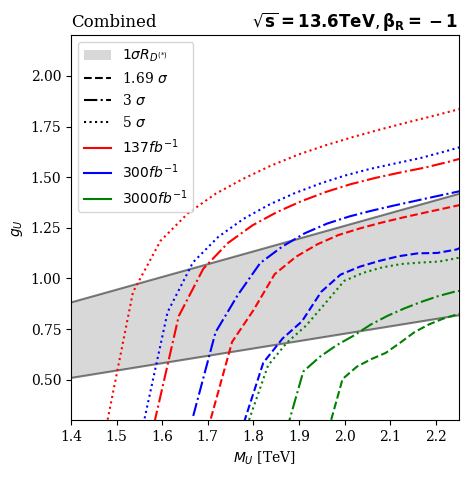

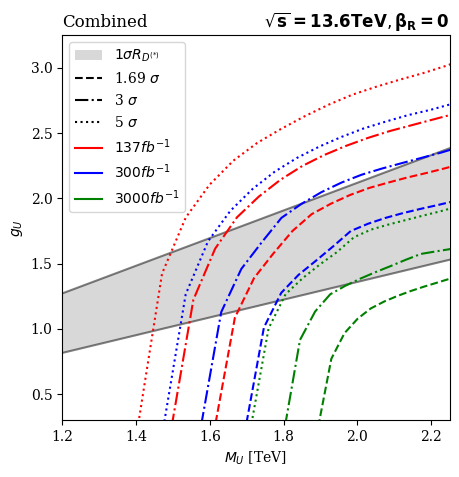

In [15]:
N = 18
colors = {'137': 'red', '300': 'blue', '3000': 'green'}

for betard in betards[:]:    
    
    fig, ax = plt.subplots(figsize = (5,5)) 
    
    if betard == 'wRHC': c_u1, c_u2 = 0.006, 0.002
    else:  c_u1, c_u2 = 0.017, 0.007

    x = np.linspace(1000/1000, 2250/1000, 1000)

    x_1, y_1 = 1000/1000, Calcular_g_U(c_u1, 1000)
    x_2, y_2 = 2250/1000, Calcular_g_U(c_u1, 2250)

    y1 = np.poly1d(np.polyfit([x_1,x_2], [y_1, y_2], deg=1))(x)

    x_3, y_3 = 1000/1000, Calcular_g_U(c_u2, 1000)
    x_4, y_4 = 2250/1000, Calcular_g_U(c_u2, 2250)

    y2 = np.poly1d(np.polyfit([x_3,x_4], [y_3, y_4], deg=1))(x)

    ax.plot(x, y1, c='black', alpha=0.5)
    ax.plot(x, y2, c='black', alpha=0.5)

    x = np.concatenate((x[0], x, x[-1]), axis = None)
    y = np.concatenate((y2[0], y1, y2[-1]), axis = None)
    ax.fill(x, y, 'gray', alpha=0.3, label = r'$1 \sigma R_{D^{(*)}}$')  
    
    curves = sigma_curves['137'][betard]
    
    #Curva de 1.69 sigma
    x1 = np.concatenate([points.vertices[:,0] for points in curves.collections[0].get_paths()])
    y1 = np.concatenate([points.vertices[:,1] for points in curves.collections[0].get_paths()])
    data1 = pd.DataFrame(y1,x1)
    data1 = data1.sort_index(ascending = True)
    data1 = data1[~data1.index.duplicated(keep='first')]
    CS = CubicSpline(data1.index, data1.values)
    data1 = pd.DataFrame(CS(np.linspace(min(data1.index), max(data1.index), N)),np.linspace(min(data1.index), max(data1.index), N))

    #Curva de 3 sigma
    x2 = np.concatenate([points.vertices[:,0] for points in curves.collections[1].get_paths()])
    y2 = np.concatenate([points.vertices[:,1] for points in curves.collections[1].get_paths()])
    data2 = pd.DataFrame(y2,x2)
    data2 = data2.sort_index(ascending = True)
    data2 = data2[~data2.index.duplicated(keep='first')]
    CS = CubicSpline(data2.index, data2.values)
    data2 = pd.DataFrame(CS(np.linspace(min(data2.index), max(data2.index), N)),np.linspace(min(data2.index), max(data2.index), N))

    #Curva de 5 sigma
    x3 = np.concatenate([points.vertices[:,0] for points in curves.collections[2].get_paths()])
    y3 = np.concatenate([points.vertices[:,1] for points in curves.collections[2].get_paths()])
    data3 = pd.DataFrame(y3,x3)
    data3 = data3.sort_index(ascending = True)
    data3 = data3[~data3.index.duplicated(keep='first')]
    CS = CubicSpline(data3.index, data3.values)
    data3 = pd.DataFrame(CS(np.linspace(min(data3.index), max(data3.index), N)),np.linspace(min(data3.index), max(data3.index), N))
    
    plt.plot(0,0, label = r'1.69 $\sigma$', linestyle = 'dashed', c = 'black')
    plt.plot(0,0, label = r'3 $\sigma$', linestyle = 'dashdot', c = 'black')
    plt.plot(0,0, label = r'5 $\sigma$', linestyle = 'dotted', c = 'black')

    plt.plot(0,0, color = colors['137'], label = r'$137 fb^{-1}$')
    plt.plot(data1, linestyle = 'dashed', color = colors['137'])
    plt.plot(data2, linestyle = 'dashdot', color = colors['137'])
    plt.plot(data3, linestyle = 'dotted', color = colors['137'])     
    
    curves = sigma_curves['300'][betard]
    
    #Curva de 1.69 sigma
    x1 = np.concatenate([points.vertices[:,0] for points in curves.collections[0].get_paths()])
    y1 = np.concatenate([points.vertices[:,1] for points in curves.collections[0].get_paths()])
    data1 = pd.DataFrame(y1,x1)
    data1 = data1.sort_index(ascending = True)
    data1 = data1[~data1.index.duplicated(keep='first')]
    CS = CubicSpline(data1.index, data1.values)
    data1 = pd.DataFrame(CS(np.linspace(min(data1.index), max(data1.index), N)),np.linspace(min(data1.index), max(data1.index), N))

    #Curva de 3 sigma
    x2 = np.concatenate([points.vertices[:,0] for points in curves.collections[1].get_paths()])
    y2 = np.concatenate([points.vertices[:,1] for points in curves.collections[1].get_paths()])
    data2 = pd.DataFrame(y2,x2)
    data2 = data2.sort_index(ascending = True)
    data2 = data2[~data2.index.duplicated(keep='first')]
    CS = CubicSpline(data2.index, data2.values)
    data2 = pd.DataFrame(CS(np.linspace(min(data2.index), max(data2.index), N)),np.linspace(min(data2.index), max(data2.index), N))

    #Curva de 5 sigma
    x3 = np.concatenate([points.vertices[:,0] for points in curves.collections[2].get_paths()])
    y3 = np.concatenate([points.vertices[:,1] for points in curves.collections[2].get_paths()])
    data3 = pd.DataFrame(y3,x3)
    data3 = data3.sort_index(ascending = True)
    data3 = data3[~data3.index.duplicated(keep='first')]
    CS = CubicSpline(data3.index, data3.values)
    data3 = pd.DataFrame(CS(np.linspace(min(data3.index), max(data3.index), N)),np.linspace(min(data3.index), max(data3.index), N))

    plt.plot(0,0, color = colors['300'], label = r'$300 fb^{-1}$')
    plt.plot(data1, linestyle = 'dashed', color = colors['300'])
    plt.plot(data2, linestyle = 'dashdot', color = colors['300'])
    plt.plot(data3, linestyle = 'dotted', color = colors['300'])    
    
    curves = sigma_curves['3000'][betard]
    
    #Curva de 1.69 sigma
    x1 = np.concatenate([points.vertices[:,0] for points in curves.collections[0].get_paths()])
    y1 = np.concatenate([points.vertices[:,1] for points in curves.collections[0].get_paths()])
    data1 = pd.DataFrame(y1,x1)
    data1 = data1.sort_index(ascending = True)
    data1 = data1[~data1.index.duplicated(keep='first')]
    CS = CubicSpline(data1.index, data1.values)
    data1 = pd.DataFrame(CS(np.linspace(min(data1.index), max(data1.index), N)),np.linspace(min(data1.index), max(data1.index), N))

    #Curva de 3 sigma
    x2 = np.concatenate([points.vertices[:,0] for points in curves.collections[1].get_paths()])
    y2 = np.concatenate([points.vertices[:,1] for points in curves.collections[1].get_paths()])
    data2 = pd.DataFrame(y2,x2)
    data2 = data2.sort_index(ascending = True)
    data2 = data2[~data2.index.duplicated(keep='first')]
    CS = CubicSpline(data2.index, data2.values)
    data2 = pd.DataFrame(CS(np.linspace(min(data2.index), max(data2.index), N)),np.linspace(min(data2.index), max(data2.index), N))

    #Curva de 5 sigma
    x3 = np.concatenate([points.vertices[:,0] for points in curves.collections[2].get_paths()])
    y3 = np.concatenate([points.vertices[:,1] for points in curves.collections[2].get_paths()])
    data3 = pd.DataFrame(y3,x3)
    data3 = data3.sort_index(ascending = True)
    data3 = data3[~data3.index.duplicated(keep='first')]
    CS = CubicSpline(data3.index, data3.values)
    data3 = pd.DataFrame(CS(np.linspace(min(data3.index), max(data3.index), N)),np.linspace(min(data3.index), max(data3.index), N))

    plt.plot(0,0, color = colors['3000'], label = r'$3000 fb^{-1}$')
    plt.plot(data1, linestyle = 'dashed', color = colors['3000'])
    plt.plot(data2, linestyle = 'dashdot', color = colors['3000'])
    plt.plot(data3, linestyle = 'dotted', color = colors['3000'])
    
    plt.legend(loc = 'upper left')
    if betard == "wRHC":
        plt.xlim(1.4,2.25)
        plt.ylim(0.3,2.2)
    else:
        plt.xlim(1.2,2.25)
        plt.ylim(0.3,3.25)
        
    plt.title(r'$\mathbf{\sqrt{s} = 13.6 TeV}$'+ betard_title[betard], loc = 'right')
    plt.title('Combined', loc = 'left')
    plt.xlabel(r'$M_{U}$ [TeV]')
    plt.ylabel(r'$g_U$')
    
    plt.savefig(f'Significances/Significance_Projections_{betard}.pdf', bbox_inches='tight')

In [16]:
!rm -rf Heatmap_Utilities/

In [17]:
# # %%capture

# ubicaciones = {'Lq_Lq_wRHC': [[1400/1000,2], [1550/1000, 2], [1650/1000, 2]],
#                'tau_Lq_wRHC': [[1400/1000,1.5], [1550/1000, 1.5], [1650/1000, 1.5]], 
#                'tau_tau_wRHC': [[1400/1000,0.8], [1550/1000, 1.25], [1650/1000, 1.5]], 
#                'Combined_wRHC':[[1600/1000,1.25], [1800/1000, 1.25], [2000/1000, 1]],
#                'Lq_Lq_woRHC': [[1400/1000,2], [1500/1000, 2], [1600/1000, 2]],
#                'tau_Lq_woRHC': [[1200/1000,1.5], [1300/1000, 1.5], [1400/1000, 1.5]], 
#                'tau_tau_woRHC': [[1400/1000,1.5], [1600/1000, 2.25], [1800/1000, 3]], 
#                'Combined_woRHC':[[1500/1000,2], [1650/1000, 1.5], [1800/1000, 1]]
#               }

# title_right = {'137': r'$\mathbf{\sqrt{s} = 13 TeV, L = 137 fb^{-1}}$', '300': r'$\mathbf{\sqrt{s} = 13.6 TeV, L = 300 fb^{-1}}$', '3000': r'$\mathbf{\sqrt{s} = 13.6 TeV, L = 3000 fb^{-1}}$'}

# sigma_curves = {}

# for key_luminosity in Significances.keys():
#     sigma_curves[key_luminosity] = {}
    
#     for betard in betards:
#         key = 'Combined'
        
#         Data = pd.DataFrame.from_dict(Significances[key_luminosity][betard][key])
#         Data.columns = [float(column)/1000 for column in Data.columns] #TeV
        
#         Data_interpolate = smooth(Data, log = True)
        
#         fig, ax, sigma_curves[key_luminosity][betard] = plot_heatmap(Data_interpolate,
#                                curvas_de_nivel = {np.log10(1.69) : r'$1.69 \sigma$', np.log10(3): r'$3 \sigma$', np.log10(5): r'$5 \sigma$'},
#                                # curves_labels_locations= ubicaciones[f'{key}_{betard}'],
#                                titulos = {'titulo':'','titulo_izquierda': titulos_izquierda[key],'titulo_derecha': title_right[key_luminosity] + betard_title[betard] ,'x_label': r'$M_{U}$ [TeV]', 'y_label': r'$g_U$', 'cbar_label': r'$\log_{10}$(Significance)'}
#                               )        
        
#         # file_name = f'Significances/Significance_Heatmap_13TeV_L{key_luminosity}_{titulos_izquierda[key]}_combined_{betard}.png'.replace('Combined', 'all')
#         #plt.savefig(file_name, bbox_inches='tight')

In [18]:
# for betard in betards:
#     Significances['300'][betard] = {}
#     Significances['3000'][betard] = {}
    
#     for key in Significances['137'][betard]:
#         Significances['300'][betard][key] = {}
#         Significances['3000'][betard][key] = {}
    
#         KFactor_13_6 = pd.read_excel(f'{path_statistical_preparation}/KFactors_13_6_TeV/{betard}/{key}.xlsx', index_col= 0)
#         KFactor_13_6.columns = [float(column) for column in KFactor_13_6.columns]
#         KFactor_13_6.index = [float(idx) for idx in KFactor_13_6.index]        
        
#         for Mass in Masses:
#             Significances['300'][betard][key][float(Mass)] = {} 
#             Significances['3000'][betard][key][float(Mass)] = {} 

#             for coupling in KFactor_13_6.index:
#                 S_137 = Significances['137'][betard][key][float(Mass)][coupling]
#                 Significances['300'][betard][key][float(Mass)][coupling] = S_137*np.sqrt(KFactor_13_6[float(Mass)][coupling]/1.109381)*np.sqrt(300/137)
#                 Significances['3000'][betard][key][float(Mass)][coupling] = S_137*np.sqrt(KFactor_13_6[float(Mass)][coupling]/1.109381)*np.sqrt(3000/137)

In [19]:
# #Combined:
# for betard in betards:
#     Significances['300'][betard]['Combined'] = {}
#     Significances['3000'][betard]['Combined'] = {}
    
#     for Mass in Masses:
#         Significances['300'][betard]['Combined'][float(Mass)] = {} 
#         Significances['3000'][betard]['Combined'][float(Mass)] = {} 
        
#         for coupling in KFactors_Matrix.index:              
#             Significances['300'][betard]['Combined'][float(Mass)][coupling] = np.sqrt(sum(np.asarray([Significances['300'][betard][signal][float(Mass)][coupling] for signal in signals])**2))
#             Significances['3000'][betard]['Combined'][float(Mass)][coupling] = np.sqrt(sum(np.asarray([Significances['3000'][betard][signal][float(Mass)][coupling] for signal in signals])**2))